In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor


# Make plots look decent
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Avoid long automatic outputs
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)

# 2. Load data
df = pd.read_csv("C:/Users/Simon/Downloads/practical_application_II_starter/data/vehicles.csv")

# Quick peek
df.head()
df.info()
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,426880.0,NaN,NaN,NaN,7311486634.224333,4473170.412559,7207408119.0,7308143339.25,7312620821.0,7315253543.5,7317101084.0
region,426880,404,columbus,3608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,426880.0,NaN,NaN,NaN,75199.033187,12182282.173604,0.0,5900.0,13950.0,26485.75,3736928711.0
year,425675.0,NaN,NaN,NaN,2011.235191,9.45212,1900.0,2008.0,2013.0,2017.0,2022.0
manufacturer,409234,42,ford,70985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,421603,29649,f-150,8009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,252776,6,good,121456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,249202,8,6 cylinders,94169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,423867,5,gas,356209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,422480.0,NaN,NaN,NaN,98043.331443,213881.500798,0.0,37704.0,85548.0,133542.5,10000000.0


In [16]:
# Keep a working copy
data = df.copy()

# Drop identifier columns that are not useful predictors
# 'id' is just an identifier; 'VIN' is too high cardinality and often missing
data = data.drop(columns=["id", "VIN"], errors="ignore")

# Basic sanity filters for the target variable (price)
# Remove listings with missing price, free cars, and absurdly high prices
data = data[data["price"].notna()]
data = data[data["price"] > 1000]           # remove $0 / junk listings
data = data[data["price"] < 100000]         # clip extreme luxury / erroneous values

# Sanity filters for year
# Restrict to roughly modern vehicles; this also drops obvious bad entries
data = data[(data["year"].notna()) & (data["year"] >= 1990) & (data["year"] <= 2022)]

# Handle odometer outliers
# Replace extremely high odometer readings with a cap (e.g., 500k miles)
data.loc[data["odometer"] > 500_000, "odometer"] = 500_000

# Remove rows missing key fields we think are critical for price
key_cols = ["manufacturer", "model", "fuel", "odometer", "title_status", "transmission"]
data = data.dropna(subset=key_cols)

# Optional: drop features with very high missingness or questionable value
# 'size' and 'cylinders' have high NA%; we can either keep and impute, or drop.
# To keep things simple and robust, drop 'size' (over 70% missing)
if "size" in data.columns:
    data = data.drop(columns=["size"])

print("Shape after cleaning:", data.shape)
data.isna().mean().sort_values(ascending=False).head(10)


Shape after cleaning: (340354, 15)


cylinders       0.411454
condition       0.376003
drive           0.293577
paint_color     0.271338
type            0.204411
region          0.000000
price           0.000000
year            0.000000
manufacturer    0.000000
model           0.000000
dtype: float64

In [17]:
data.head(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,al
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
32,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al
33,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al
34,auburn,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al
35,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al
36,auburn,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,gas,30237.0,clean,other,rwd,other,red,al


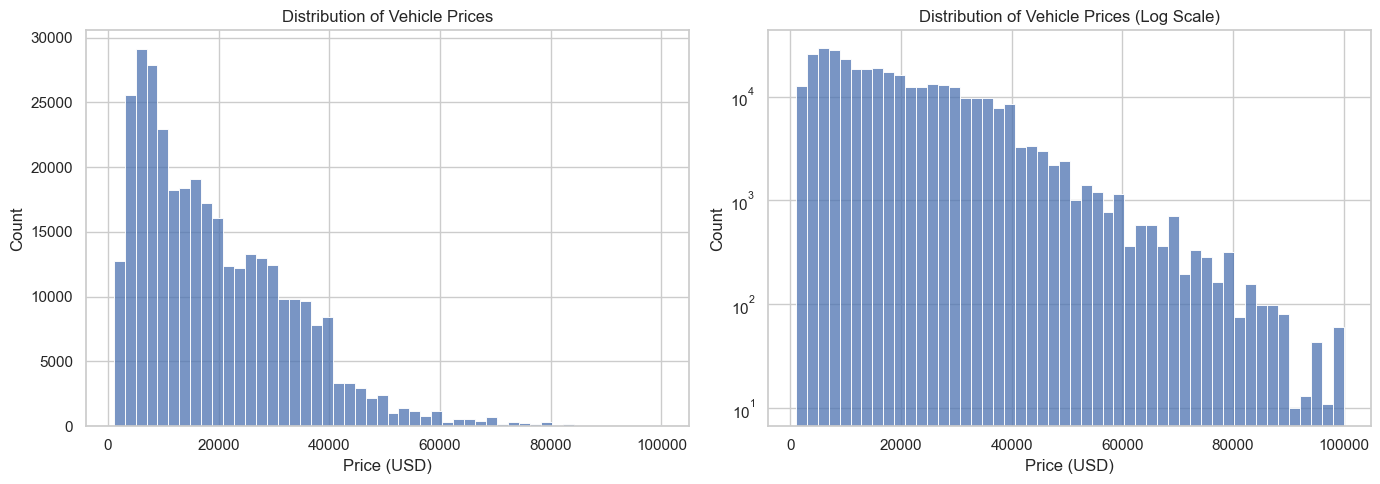

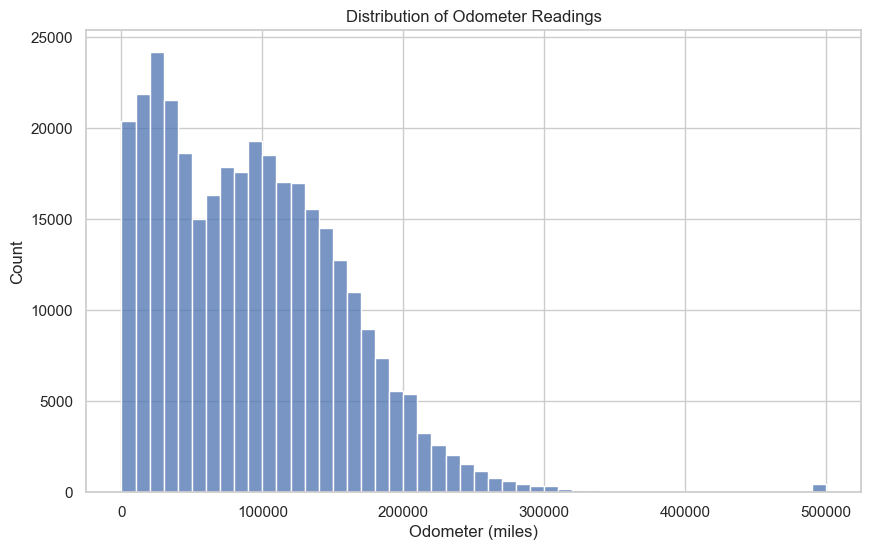

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price distribution (use log scale because prices are right-skewed)
sns.histplot(data["price"], bins=50, ax=axes[0])
axes[0].set_title("Distribution of Vehicle Prices")
axes[0].set_xlabel("Price (USD)")
axes[0].set_ylabel("Count")

sns.histplot(data["price"], bins=50, ax=axes[1])
axes[1].set_title("Distribution of Vehicle Prices (Log Scale)")
axes[1].set_xlabel("Price (USD)")
axes[1].set_ylabel("Count")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

# Odometer distribution
plt.figure()
sns.histplot(data["odometer"], bins=50)
plt.title("Distribution of Odometer Readings")
plt.xlabel("Odometer (miles)")
plt.ylabel("Count")
plt.show()


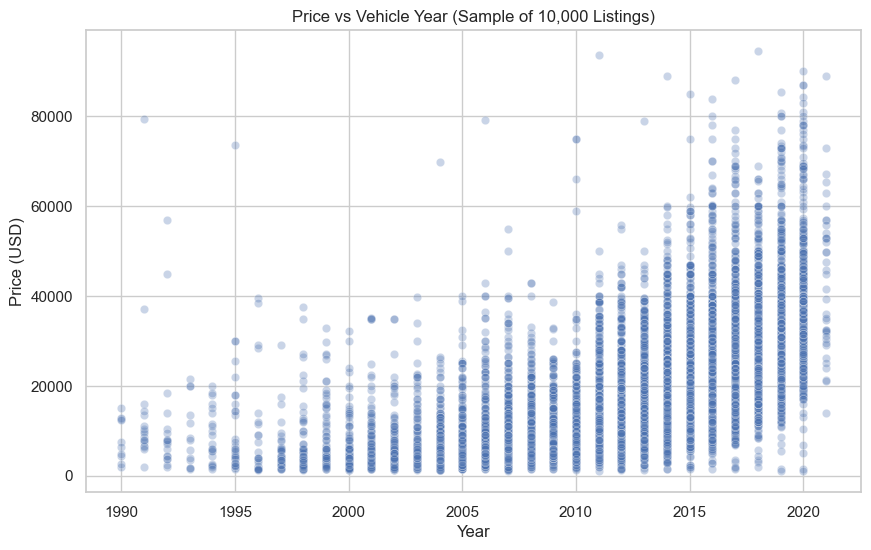

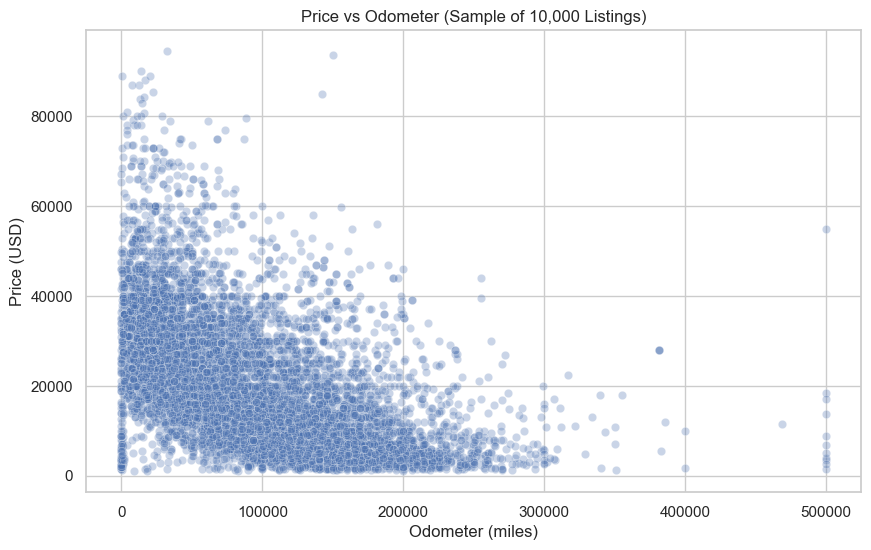

In [19]:
# Scatter: price vs year
plt.figure()
sns.scatterplot(data=data.sample(10000, random_state=0), x="year", y="price", alpha=0.3)
plt.title("Price vs Vehicle Year (Sample of 10,000 Listings)")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.show()

# Scatter: price vs odometer
plt.figure()
sns.scatterplot(data=data.sample(10000, random_state=0), x="odometer", y="price", alpha=0.3)
plt.title("Price vs Odometer (Sample of 10,000 Listings)")
plt.xlabel("Odometer (miles)")
plt.ylabel("Price (USD)")
plt.show()


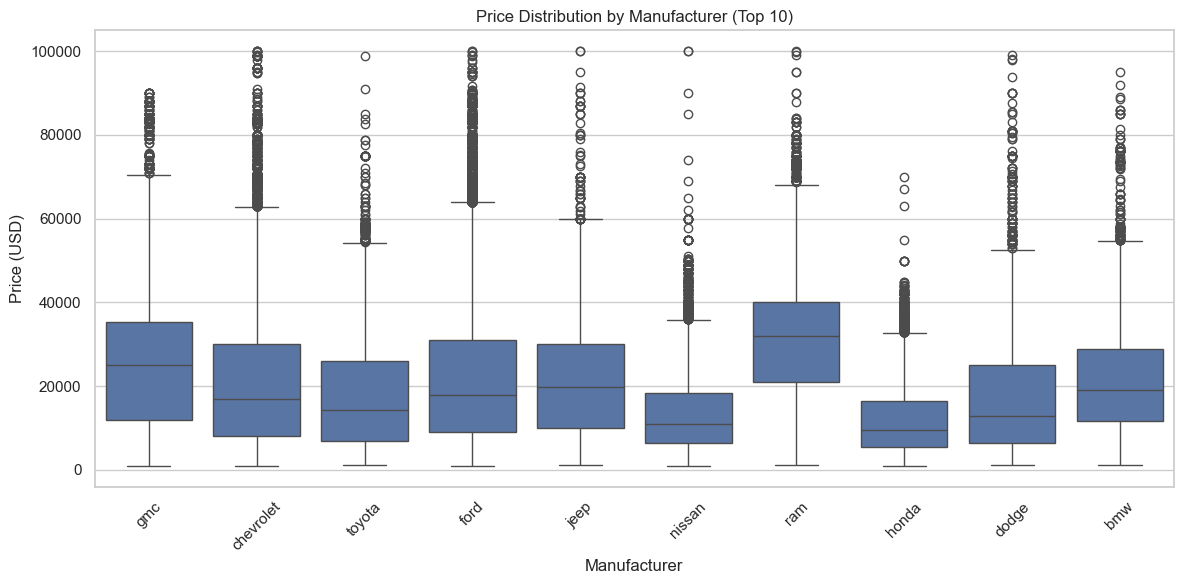

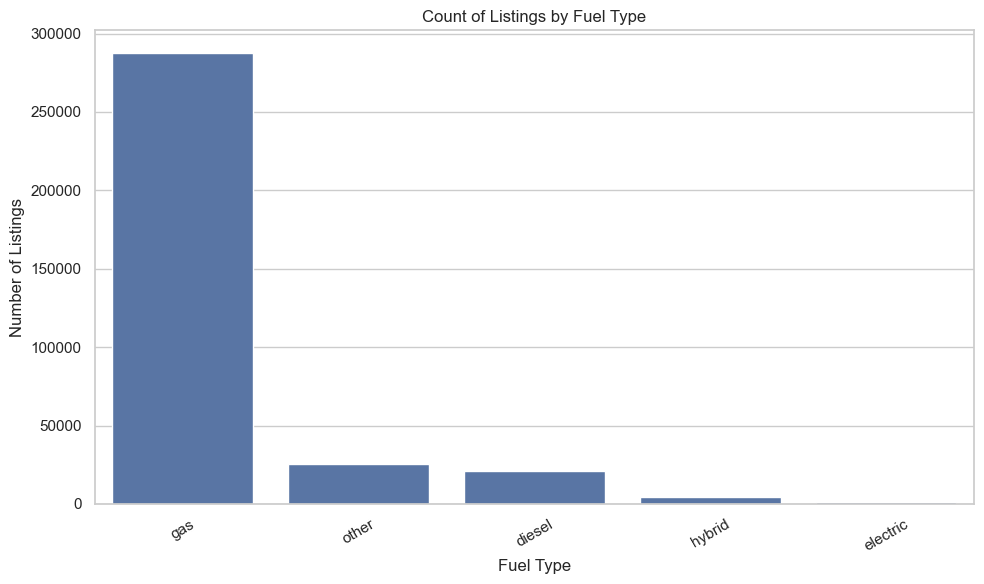

In [20]:
# Boxplots for top manufacturers

# Get top 10 manufacturers by count
top_makes = data["manufacturer"].value_counts().nlargest(10).index
subset = data[data["manufacturer"].isin(top_makes)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=subset, x="manufacturer", y="price")
plt.title("Price Distribution by Manufacturer (Top 10)")
plt.xlabel("Manufacturer")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Countplot of fuel types
plt.figure()
sns.countplot(data=data, x="fuel", order=data["fuel"].value_counts().index)
plt.title("Count of Listings by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Number of Listings")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [29]:
target = "price"

# Updated feature list (model removed to avoid huge one-hot encoding explosion)
feature_cols = [
    "year",
    "odometer",
    "manufacturer",
    "condition",
    "cylinders",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "type",
    "paint_color",
    "state"
]

# Keep only selected features + target
data_model = data[[target] + feature_cols].copy()

# Define X and y
X = data_model[feature_cols]
y = data_model[target]

# Split numeric vs categorical
numeric_features = ["year", "odometer"]
categorical_features = [col for col in feature_cols if col not in numeric_features]

# Numeric transformer (no scaling needed for linear regression with one-hot)
numeric_transformer = "passthrough"

# Categorical transformer with sparse output to prevent memory issues
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=True
)

# ColumnTransformer to apply the correct preprocessing to each column type
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((272283, 12), (68071, 12))

In [31]:
def evaluate_regression_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """Utility to compute and print RMSE, MAE, and R^2 for a fitted model."""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rmse_train = mean_squared_error(y_train, y_pred_train)**0.5
    rmse_test  = mean_squared_error(y_test, y_pred_test)**0.5
    
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"{model_name} performance:")
    print(f"  Train RMSE: {rmse_train:,.0f}")
    print(f"  Test RMSE : {rmse_test:,.0f}")
    print(f"  Test MAE  : {mae_test:,.0f}")
    print(f"  Test R^2  : {r2_test:.3f}")

# Linear Regression pipeline
linreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)

evaluate_regression_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")


Linear Regression performance:
  Train RMSE: 7,990
  Test RMSE : 7,988
  Test MAE  : 5,699
  Test R^2  : 0.679


In [47]:
# Get feature names from the preprocessor
ohe = linreg.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

coefs = linreg.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
coef_df.sort_values(by="coefficient", ascending=False).head(10)
coef_df.sort_values(by="coefficient", ascending=True).head(10)

,feature,coefficient
60,fuel_gas,-5594.332270
73,drive_fwd,-3523.130688
52,cylinders_4 cylinders,-3436.102689
76,type_SUV,-2298.118514
85,type_sedan,-1877.874302
80,type_hatchback,-1734.281657
31,manufacturer_nissan,-1682.498209
75,drive_nan,-1529.632757
18,manufacturer_hyundai,-1124.107776
22,manufacturer_kia,-1061.445787


In [33]:
feature_names = []
feature_names.extend(numeric_features)
feature_names.extend(cat_feature_names)

coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
coef_df

,feature,coefficient
0,year,1018.006749
1,odometer,-0.066934
2,manufacturer_acura,184.976427
3,manufacturer_alfa-romeo,22.675661
4,manufacturer_aston-martin,7.044200
...,...,...
149,state_vt,-131.705851
150,state_wa,1230.999967
151,state_wi,-441.177452
152,state_wv,34.915857


In [37]:
def cross_val_rmse(pipeline, X, y, cv=5):
    """Return cross-validated RMSE scores."""
    neg_mse_scores = cross_val_score(
        pipeline,
        X,
        y,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=-1
    )
    rmse_scores = np.sqrt(-neg_mse_scores)
    return rmse_scores

# Baseline CV (Linear Regression)
linreg_cv_rmse = cross_val_rmse(linreg, X, y)
print("Linear Regression CV RMSE:", linreg_cv_rmse.mean().round(0), "+/-", linreg_cv_rmse.std().round(0))


Linear Regression CV RMSE: 8066.0 +/- 321.0


In [40]:
# Ridge Regression pipeline
ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge(random_state=42))
])

# Hyperparameter grid for Ridge (alpha controls regularization strength)
param_grid_ridge = {
    "model__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]
}

# Grid search with cross-validation
ridge_grid = GridSearchCV(
    ridge,
    param_grid=param_grid_ridge,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_grid.best_params_["model__alpha"])

# Best Ridge model
ridge_best = ridge_grid.best_estimator_

# Evaluate best Ridge model
evaluate_regression_model(ridge_best, X_train, y_train, X_test, y_test, "Ridge Regression")

# Best CV RMSE from the grid search
ridge_cv_rmse = np.sqrt(-ridge_grid.best_score_)
print("Ridge best CV RMSE:", f"{ridge_cv_rmse:,.0f}")

Best Ridge alpha: 0.1
Ridge Regression performance:
  Train RMSE: 11,768
  Test RMSE : 11,711
  Test MAE  : 8,766
  Test R^2  : 0.309
Ridge best CV RMSE: 11,768


In [42]:
results = []

def add_result(name, model, X_train, y_train, X_test, y_test):
    y_pred_test = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred_test)**0.5
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    r2_test   = r2_score(y_test, y_pred_test)
    results.append({
        "model": name,
        "test_rmse": rmse_test,
        "test_mae": mae_test,
        "test_r2": r2_test
    })

add_result("Linear Regression", linreg, X_train, y_train, X_test, y_test)
add_result("Ridge Regression", ridge_best, X_train, y_train, X_test, y_test)

results_df = pd.DataFrame(results)
results_df

,model,test_rmse,test_mae,test_r2
0,Linear Regression,7987.614202,5699.195277,0.678729
1,Ridge Regression,11711.136461,8765.787553,0.309386


In [45]:
# Coefficients from Linear Regression
ohe = linreg.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

linreg_feature_names = []
linreg_feature_names.extend(numeric_features)
linreg_feature_names.extend(cat_feature_names)

linreg_coefs = linreg.named_steps["model"].coef_

linreg_coef_df = pd.DataFrame({
    "feature": linreg_feature_names,
    "coefficient": linreg_coefs
})
linreg_coef_df["abs_coef"] = linreg_coef_df["coefficient"].abs()

# Look at numeric features
linreg_coef_df[linreg_coef_df["feature"].isin(numeric_features)]

# Top 15 features by absolute coefficient magnitude
linreg_coef_df.sort_values("abs_coef", ascending=False).head(10)


,feature,coefficient,abs_coef
58,fuel_diesel,6438.183005,6438.183005
60,fuel_gas,-5594.332270,5594.332270
55,cylinders_8 cylinders,3891.728648,3891.728648
73,drive_fwd,-3523.130688,3523.130688
52,cylinders_4 cylinders,-3436.102689,3436.102689
72,drive_4wd,3402.209659,3402.209659
86,type_truck,3303.646220,3303.646220
84,type_pickup,2422.129013,2422.129013
76,type_SUV,-2298.118514,2298.118514
34,manufacturer_ram,1982.544099,1982.544099


In [49]:
ridge_ohe = ridge_best.named_steps["preprocess"].named_transformers_["cat"]
ridge_cat_feature_names = ridge_ohe.get_feature_names_out(categorical_features)

ridge_feature_names = []
ridge_feature_names.extend(numeric_features)
ridge_feature_names.extend(ridge_cat_feature_names)

ridge_coefs = ridge_best.named_steps["model"].coef_

ridge_coef_df = pd.DataFrame({
    "feature": ridge_feature_names,
    "coefficient": ridge_coefs
})
ridge_coef_df["abs_coef"] = ridge_coef_df["coefficient"].abs()

ridge_coef_df[ ridge_coef_df["feature"].isin(numeric_features) ]
ridge_coef_df.sort_values("abs_coef", ascending=False).head(10)


,feature,coefficient,abs_coef
1,odometer,-1.200682e-01,1.200682e-01
0,year,1.174712e-05,1.174712e-05
73,drive_fwd,-4.159659e-07,4.159659e-07
60,fuel_gas,-3.877266e-07,3.877266e-07
71,transmission_other,3.768152e-07,3.768152e-07
72,drive_4wd,3.721193e-07,3.721193e-07
52,cylinders_4 cylinders,-3.507733e-07,3.507733e-07
69,transmission_automatic,-3.213995e-07,3.213995e-07
84,type_pickup,2.568377e-07,2.568377e-07
85,type_sedan,-2.486488e-07,2.486488e-07
